In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_2496/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
import copy
import hist
from coffea import util
import numpy as np
import itertools
import pandas as pd
import mplhep as hep
import HelpfulPlottingDefs as hpd

# Select Year and Choice of VFP (pre or post)
### 2017 and 2018 are postVFP Only

In [3]:
Year = 2016
btagWP = 'MediumBTag'
vfp = 'postVFP'
saveOn = False
saveCSVOn = False

In [4]:
dir1 = 'CoffeaOutputsForCombine/Coffea_FirstRun/'

if btagWP != '':
    btagdir = f'{btagWP}/'
else:
    btagdir = btagWP
    
yeardir = f'{str(Year)}/'
btagType = 'DeepCSV'
APVDir = {
    'preVFP': 'APV/',
    'postVFP': 'noAPV/'
}

od = ''
oddir = ''
if btagdir == '':
    od = '_oldANdisc'
    oddir = f'Old{str(Year)}_MediumBTag/'

# Load All Data Eras

In [5]:
from LoadData import JetHT_Unweighted

JetHT_unweighted = JetHT_Unweighted(btagWP, Year)

# Load All MC

In [6]:
import LoadMC as LM

TTbar_unweighted = LM.TTbar_Unweighted(btagWP, Year)

# Categories

In [7]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at"] #, "0t", "1t", "It", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
list_of_ints = [6, 7, 8, 9, 10, 11]
catmap = dict(zip(list_of_ints, list_of_cats))

In [8]:
# ---- Optional to rescale x-axis of mistag rates ---- #
def forward(x):
    return x**(1/8)

def inverse(x):
    return x**8

# Luminosities, Cross Sections & Scale Factors

In [9]:
Lum2016 = 35920. # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable
Lum2017 = 41530.
Lum2018 = 59740.
Lum     = 137190.

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 0.7

if Year == 2016:
    if vfp == 'preVFP':
        Lum_frac = 19800. 
    else:
        Lum_frac = Lum2016 - 19800.
        
elif Year == 2017:
    Lum_frac = Lum2017
    
elif Year == 2018:
    Lum_frac = Lum2018
    
else:
    Lum_frac = Lum

# =========== SF =========== #
ttbar_sf1 = Lum_frac*ttbar_xs1*toptag_sf**2*toptag_kf/TTbar_unweighted[f'700_1000_{vfp}']['cutflow']['sumw']
ttbar_sf2 = Lum_frac*ttbar_xs2*toptag_sf**2*toptag_kf/TTbar_unweighted[f'1000_Inf_{vfp}']['cutflow']['sumw']

ttbar_scales = [ttbar_sf1, ttbar_sf2]

# Mistag Rates with $t\bar{t}$ Subtraction and Inclusive $y$ Region Sorted by b-tag Region

In [10]:
maindirectory = os.getcwd() 
SaveDirectory = f'{maindirectory}/BkgEstimate/MistagPlots/{yeardir}{btagdir}{oddir}{btagType}/{APVDir[vfp]}' # split histograms into subdirectories
hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already

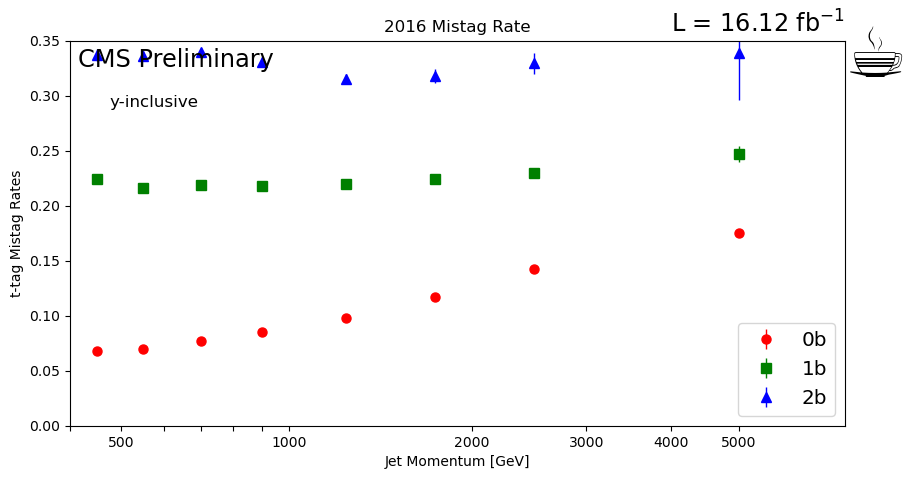

In [11]:
# =================================================================================================== #

fig, ax = plt.subplots(
    figsize=(10,5),
    sharex=True
)
HIP = ''
if vfp == 'preVFP':
    HIP = ' (with HIP)'
title = f'{str(Year)}{HIP} Mistag Rate'

# =================================================================================================== #

Inc0b = hpd.GetMistagInfo(JetHT_unweighted, 0, Year, vfp)
Inc1b = hpd.GetMistagInfo(JetHT_unweighted, 1, Year, vfp)
Inc2b = hpd.GetMistagInfo(JetHT_unweighted, 2, Year, vfp)
            
# =================================================================================================== #

mistag_inclusive0b = hpd.plotratio(Inc0b['Num'], Inc0b['Denom'], ax = ax, histtype='errorbar', 
                           marker='.', markersize=13., color='r')

mistag_inclusive1b = hpd.plotratio(Inc1b['Num'], Inc1b['Denom'], ax = ax, histtype='errorbar', 
                           marker='s', markersize=7., color='g')

mistag_inclusive2b = hpd.plotratio(Inc2b['Num'], Inc2b['Denom'], ax = ax, histtype='errorbar', 
                           marker='^', markersize=7., color='b')

# =================================================================================================== #

plt.ylim(bottom = 0.0, top = 0.35)
plt.xlim([400,7000])

ax.set_ylabel('t-tag Mistag Rates')
ax.set_title(title)
leg = ax.legend(labels=["0b", "1b", "2b"],fontsize='x-large')

# ---- Optional x-axis scaling ---- #
ax.set_xscale('function', functions=(forward, inverse))
plt.xticks(np.array([400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]))
ax.set_xticklabels(['', 500, '', '', '', '', 1000, 2000, 3000, 4000, 5000])

#---- Labeling ----#
Lint = str(Lum_frac*.001) # Integrated Luminosity
lumi = plt.text(1.0, 1.08, "L = " + Lint[:6] + " fb$^{-1}$",
        fontsize='xx-large',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )
CMS = plt.text(0.01, 0.98, 'CMS Preliminary',
        fontsize='xx-large',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
       )
rap = plt.text(0.05, 0.86, 'y-inclusive',
        fontsize='large',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
       )
coffee = plt.text(1.0, 0.87, u"☕",
              fontsize=50,
              horizontalalignment='left',
              verticalalignment='bottom',
              transform=ax.transAxes
             )

# =================================================================================================== #
if saveOn:
    filename = f'InclusiveMistag.png'
    plt.savefig(SaveDirectory+filename, bbox_inches="tight")
    print('\n' + SaveDirectory + filename + ' saved')

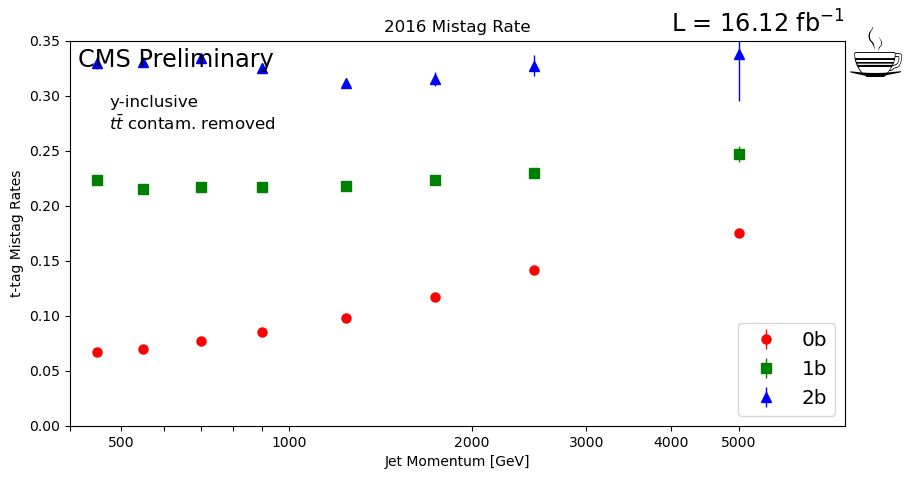

In [12]:
# =================================================================================================== #

fig, ax = plt.subplots(
    figsize=(10,5),
    sharex=True
)
HIP = ''
if vfp == 'preVFP':
    HIP = ' (with HIP)'
title = f'{str(Year)}{HIP} Mistag Rate'

# =================================================================================================== #

inc0b = hpd.GetMistagInfoCR(TTbar_unweighted, JetHT_unweighted, 0, Year, vfp, ttbar_scales)
inc1b = hpd.GetMistagInfoCR(TTbar_unweighted, JetHT_unweighted, 1, Year, vfp, ttbar_scales)
inc2b = hpd.GetMistagInfoCR(TTbar_unweighted, JetHT_unweighted, 2, Year, vfp, ttbar_scales)
            
# =================================================================================================== #

mistag_inclusive0b_cr = hpd.plotratio(inc0b['Num'], inc0b['Denom'], ax = ax, histtype='errorbar', 
                           marker='.', markersize=13., color='r')

mistag_inclusive1b_cr = hpd.plotratio(inc1b['Num'], inc1b['Denom'], ax = ax, histtype='errorbar', 
                           marker='s', markersize=7., color='g')

mistag_inclusive2b_cr = hpd.plotratio(inc2b['Num'], inc2b['Denom'], ax = ax, histtype='errorbar', 
                           marker='^', markersize=7., color='b')

# =================================================================================================== #

plt.ylim(bottom = 0.0, top = 0.35)
plt.xlim([400,7000])

ax.set_ylabel('t-tag Mistag Rates')
ax.set_title(title)
leg = ax.legend(labels=["0b", "1b", "2b"],fontsize='x-large')

# ---- Optional x-axis scaling ---- #
ax.set_xscale('function', functions=(forward, inverse))
plt.xticks(np.array([400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]))
ax.set_xticklabels(['', 500, '', '', '', '', 1000, 2000, 3000, 4000, 5000])

#---- Labeling ----#
Lint = str(Lum_frac*.001) # Integrated Luminosity
lumi = plt.text(1.0, 1.08, "L = " + Lint[:6] + " fb$^{-1}$",
        fontsize='xx-large',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )
CMS = plt.text(0.01, 0.98, 'CMS Preliminary',
        fontsize='xx-large',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
       )
rap = plt.text(0.05, 0.86, 'y-inclusive',
        fontsize='large',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
       )
contam = plt.text(0.05, 0.81, r'$t\bar{t}$ contam. removed',
        fontsize='large',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
       )
coffee = plt.text(1.0, 0.87, u"☕",
              fontsize=50,
              horizontalalignment='left',
              verticalalignment='bottom',
              transform=ax.transAxes
             )

# =================================================================================================== #
if saveOn:
    filename = f'InclusiveMistag_ContamRemoved.png'
    plt.savefig(SaveDirectory+filename, bbox_inches="tight")
    print('\n' + SaveDirectory + filename + ' saved')

# Make this the new script for making mistag rate lookup tables
### Note to AC: Remove old method later and replace that script with condensed version of this (somehow...)

In [13]:
momentum = []
xaxis = inc0b['Num'].axes['jetp']
for p in xaxis:
    momentum.append(p)
# momentum

In [14]:
mistags0b = mistag_inclusive0b_cr[0][0][0].get_ydata()
mistags1b = mistag_inclusive1b_cr[0][0][0].get_ydata()
mistags2b = mistag_inclusive2b_cr[0][0][0].get_ydata()
mistags0b[np.isnan(mistags0b)] = 0
mistags1b[np.isnan(mistags1b)] = 0
mistags2b[np.isnan(mistags2b)] = 0

In [15]:
d0 = {'p': momentum, 'M(p)': mistags0b}
d1 = {'p': momentum, 'M(p)': mistags1b}
d2 = {'p': momentum, 'M(p)': mistags2b}
df0 = pd.DataFrame(data=d0)
df1 = pd.DataFrame(data=d1)
df2 = pd.DataFrame(data=d2)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(df0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(df1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(df2)

                   p      M(p)
0     (400.0, 500.0)  0.067456
1     (500.0, 600.0)  0.069539
2     (600.0, 800.0)  0.076679
3    (800.0, 1000.0)  0.084859
4   (1000.0, 1500.0)  0.098193
5   (1500.0, 2000.0)  0.117168
6   (2000.0, 3000.0)  0.142011
7   (3000.0, 7000.0)  0.174870
8  (7000.0, 10000.0)  0.000000
                   p      M(p)
0     (400.0, 500.0)  0.223077
1     (500.0, 600.0)  0.214894
2     (600.0, 800.0)  0.217119
3    (800.0, 1000.0)  0.216607
4   (1000.0, 1500.0)  0.218383
5   (1500.0, 2000.0)  0.223661
6   (2000.0, 3000.0)  0.229492
7   (3000.0, 7000.0)  0.246927
8  (7000.0, 10000.0)  0.000000
                   p      M(p)
0     (400.0, 500.0)  0.330021
1     (500.0, 600.0)  0.330269
2     (600.0, 800.0)  0.334121
3    (800.0, 1000.0)  0.325265
4   (1000.0, 1500.0)  0.311563
5   (1500.0, 2000.0)  0.314919
6   (2000.0, 3000.0)  0.327293
7   (3000.0, 7000.0)  0.337676
8  (7000.0, 10000.0)  0.000000


In [16]:
MistagLocation = f'{maindirectory}/LookupTables/{btagdir}' 
hpd.DoesDirectoryExist(MistagLocation) 

In [17]:
df0_name = f'mistag_UL{yeardir[-3:4]}{vfp}_JetHT_Data_ttContaminationRemoved_at0binc.csv'
df1_name = f'mistag_UL{yeardir[-3:4]}{vfp}_JetHT_Data_ttContaminationRemoved_at1binc.csv'
df2_name = f'mistag_UL{yeardir[-3:4]}{vfp}_JetHT_Data_ttContaminationRemoved_at2binc.csv'
print(MistagLocation+df0_name)
print(MistagLocation+df1_name)
print(MistagLocation+df2_name)

/home/cms-jovyan/TTbarAllHadUproot/LookupTables/MediumBTag/mistag_UL16postVFP_JetHT_Data_ttContaminationRemoved_at0binc.csv
/home/cms-jovyan/TTbarAllHadUproot/LookupTables/MediumBTag/mistag_UL16postVFP_JetHT_Data_ttContaminationRemoved_at1binc.csv
/home/cms-jovyan/TTbarAllHadUproot/LookupTables/MediumBTag/mistag_UL16postVFP_JetHT_Data_ttContaminationRemoved_at2binc.csv


In [18]:
if saveCSVOn:
    df0.to_csv(MistagLocation+df0_name)
    df1.to_csv(MistagLocation+df1_name)
    df2.to_csv(MistagLocation+df2_name)